In [253]:
from No_sync.Frost_api import client_id, client_secret
import requests
import pandas as pd
from datetime import datetime, timedelta

In [254]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [255]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [256]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

<h2>API Call</h2>

In [257]:
# SN65320, SN65310, SN65370 
# Closest station gave error, so I used the second closest station
# air_temperature, precipitation_amount, wind_speed, relative_humidity, 

In [258]:
df_fish = spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_table_year", keyspace="fish_keyspace").load()

# filter out the columns we want - name, lon, lat and localityno
df_fish = df_fish.select("name", "lon", "lat", "localityno")

# get the unique localityno
df_fish = df_fish.dropDuplicates(['localityno'])

# show the dataframe
df_fish.show()

# convert to pandas dataframe
df_fish = df_fish.toPandas()


+------------+--------+---------+----------+
|        name|     lon|      lat|localityno|
+------------+--------+---------+----------+
| Tuholmane Ø|5.216333|59.371233|     10029|
| Giljeholmen| 4.96755|60.339883|     10037|
|      Sørvik|5.102933| 59.88065|     10040|
| Kviksholmen|5.090733|60.054317|     10041|
|    Goddosen| 5.13615|59.862167|     10044|
|   Eidholmen|5.120633|60.088083|     10045|
|     Ospøy Ø|5.228133|59.866567|     10050|
|Klubbeosen I|5.249333|59.831133|     10052|
|Tobbeholmane| 5.30815|60.024317|     10054|
|        Fjon|5.445748| 59.51161|     10060|
| Parisvatnet|4.801797|60.628999|     10062|
| Toskasundet|4.956108|60.653536|     10071|
|  Rylandsvåg|5.044073|60.561573|     10076|
|   Tveitevåg|5.133024|60.445729|     10077|
|      Mjånes|  5.0304|60.997733|     10078|
|   Laksevika| 5.11575| 60.53015|     10080|
|    Rekeviki|5.328583|60.723417|     10086|
|   Kalvøya N|4.708333|    61.32|     10087|
|  Trellevika|  5.0185|61.370383|     10090|
|     Vågs

In [259]:
df_fish.head()



,name,lon,lat,localityno
0,Tuholmane Ø,5.216333,59.371233,10029
1,Giljeholmen,4.967550,60.339883,10037
2,Sørvik,5.102933,59.880650,10040
3,Kviksholmen,5.090733,60.054317,10041
4,Goddosen,5.136150,59.862167,10044


In [260]:
# Get closest station(s) to the location

def get_closest_station(lat = '63.469217', lon = '7.8523', num_stations = 5, client_id = client_id):
    # Get the closest station to the location
    
    url = f"https://frost.met.no/sources/v0.jsonld?geometry=nearest(POINT({lon}%20{lat}))&nearestmaxcount={num_stations}"
    response = requests.get(url, auth=(client_id, ''))
    if response.status_code == 200:
        json_data = response.json()
        #print(json_data)
        #print(json_data['data'][0]['id'])
        
        # return a list of the id of the closest stations
        return [json_data['data'][i]['id'] for i in range(num_stations)]
        

    else:
        print("Error! Returned status code %s" % response.status_code)
        return None
    
# Get the closest station to the location id
df_station = get_closest_station(lat = '63.469217', lon = '7.8523', client_id = client_id, num_stations = 5)


In [261]:
# check if the following columns 
print(df_station)



['SN65320', 'SN65310', 'SN65370', 'SN65130', 'SN64320']


In [262]:
def fetch_weather_data(client_id, df_station, year=None):
    # Define the endpoint and parameters
    endpoint = 'https://frost.met.no/observations/v0.jsonld'

    if year:
        # Calculate the date range for the specified year
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    else:
        # Calculate the date range for the last year
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365)

    # Format the date range as a string
    date_range = start_date.strftime('%Y-%m-%d') + '/' + end_date.strftime('%Y-%m-%d')

    # make a string of the station id's
    df_station = ','.join(df_station)
    
    parameters = {
        'sources': df_station,
        'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),mean(relative_humidity P1D)',
        'referencetime': date_range,
    }

    # Issue an HTTP GET request
    r = requests.get(endpoint, params=parameters, auth=(client_id, ''))

    # Check if the request was successful
    if r.status_code == 200:
        # Extract JSON data
        json_data = r.json()
        print('Data retrieved from frost.met.no!')
        return json_data
        
    else:
        print(f"Failed to fetch data. Status code: {r.status_code}, need most likely more stations")
        return None

# Example usage:

json = fetch_weather_data(client_id, year=2021, df_station=df_station)

data = json['data']

Data retrieved from frost.met.no!


<h2>From JSON to pandas dataframe</h2>

In [263]:
# make a dataframe
df_total = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']

    df_total = pd.concat([row, df_total])

In [264]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [265]:
#get unique values in elementId
df['elementId'].unique()

array(['sum(precipitation_amount P1D)', 'mean(air_temperature P1D)',
       'mean(wind_speed P1D)', 'mean(relative_humidity P1D)'],
      dtype=object)

<h2>Plots for fun</h2>

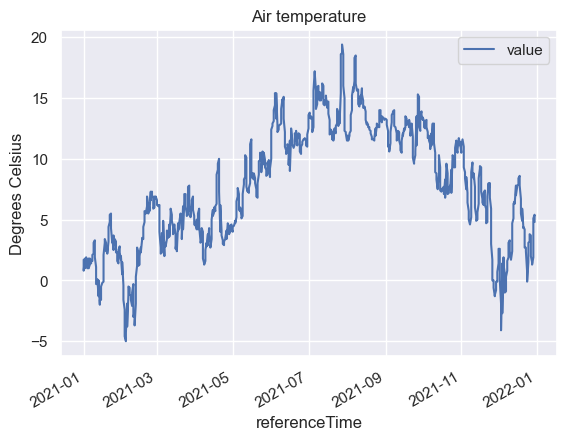

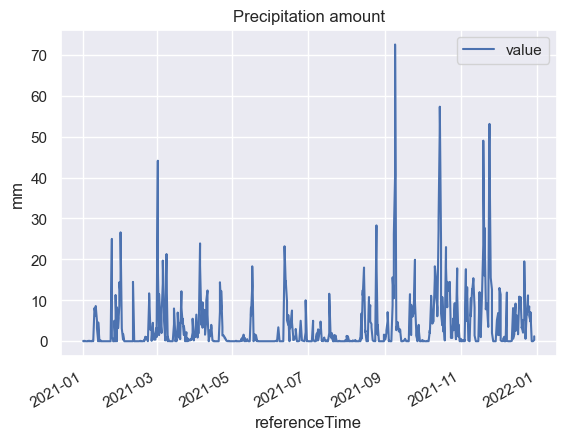

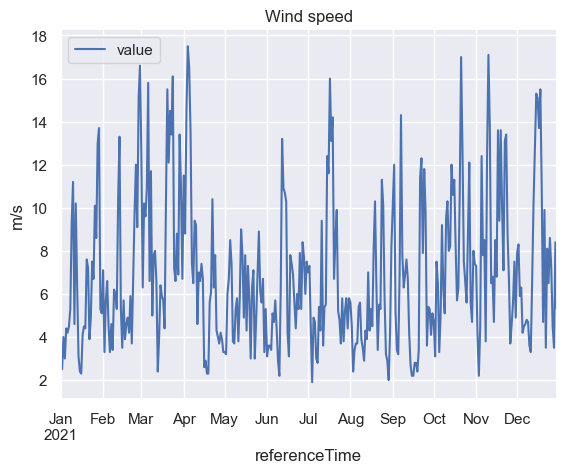

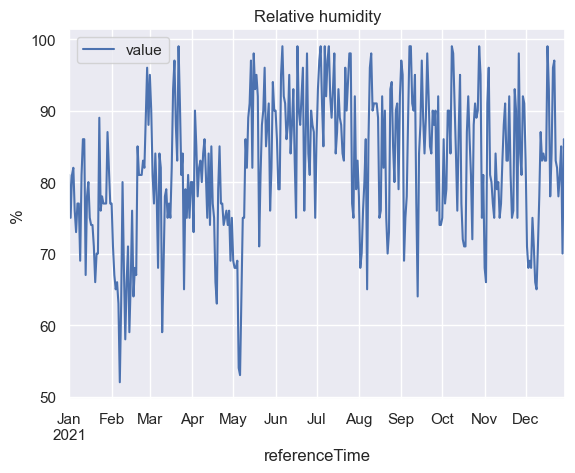

In [266]:
# plot values for each element based on time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plot air_temperature
df_air_temperature = df[df['elementId'] == 'mean(air_temperature P1D)']
df_air_temperature = df_air_temperature[['referenceTime','value']]
df_air_temperature = df_air_temperature.set_index('referenceTime')
df_air_temperature.plot()
plt.title('Air temperature')
plt.ylabel('Degrees Celsius')
plt.show()

# plot precipitation_amount
df_precipitation_amount = df[df['elementId'] == 'sum(precipitation_amount P1D)']
df_precipitation_amount = df_precipitation_amount[['referenceTime','value']]
df_precipitation_amount = df_precipitation_amount.set_index('referenceTime')
df_precipitation_amount.plot()
plt.title('Precipitation amount')
plt.ylabel('mm')
plt.show()

# plot wind_speed
df_wind_speed = df[df['elementId'] == 'mean(wind_speed P1D)']
df_wind_speed = df_wind_speed[['referenceTime','value']]
df_wind_speed = df_wind_speed.set_index('referenceTime')
df_wind_speed.plot()
plt.title('Wind speed')
plt.ylabel('m/s')
plt.show()

# plot relative_humidity
df_relative_humidity = df[df['elementId'] == 'mean(relative_humidity P1D)']
df_relative_humidity = df_relative_humidity[['referenceTime','value']]
df_relative_humidity = df_relative_humidity.set_index('referenceTime')
df_relative_humidity.plot()
plt.title('Relative humidity')
plt.ylabel('%')
plt.show()




In [267]:
# Convert all column names to lower case
df.columns = df.columns.str.lower()

# make df to csv
df.to_csv('Data/weather.csv', index=False)

<h2>Connecting to Cassandra Cluster</h2>

In [268]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [269]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [270]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [271]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.weather_table;") 

# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS weather_table (
    sourceid TEXT,
    elementid TEXT,
    value DOUBLE,
    unit TEXT,
    timeoffset TEXT,
    referencetime DATE,
    PRIMARY KEY (elementid, timeoffset, referencetime)
);
""")


<h2>From Pandas dataframe to Spark dataframe</h2>

In [272]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [273]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [274]:
# Read the data from the csv files
weather_data = spark.read.csv('Data/weather.csv', header=True, inferSchema=True)

In [275]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "weather_table"

weather_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [276]:
# Read from Cassandra - fish_table_year
df_weather = spark.read.format("org.apache.spark.sql.cassandra").options(table="weather_table", keyspace="fish_keyspace").load()
df_weather.show()

+--------------------+----------+-------------+---------+----+-----+
|           elementid|timeoffset|referencetime| sourceid|unit|value|
+--------------------+----------+-------------+---------+----+-----+
|sum(precipitation...|      PT6H|   2021-01-01|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-02|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-03|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-04|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-05|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-06|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-07|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-08|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-09|SN64320:0|  mm|  0.0|
|sum(precipitation...|      PT6H|   2021-01-10|SN64320:0|  mm|  7.7|
|sum(precipitation...|      PT6H|   2021-01-11|SN64320:0|  mm|  6.3|
|sum(precipitation...|      PT6H| 

In [277]:
# make a pandas dataframe
df_weather = df_weather.toPandas()

In [278]:
# get the first date in the week
df_weather['referencetime'] = pd.to_datetime(df_weather['referencetime'])
df_weather['week'] = df_weather['referencetime'].dt.isocalendar().week
df_weather['year'] = df_weather['referencetime'].dt.isocalendar().year

<h1>Part 2 - transform data

In [279]:
# read from Cassandra - fish_table_year 
lice_count_table = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()

# turn the dataframes into pandas dataframes
lice_count_table = lice_count_table.toPandas()

# drop columns where all values are null or nan
lice_count_table = lice_count_table.dropna(axis=1, how='all')

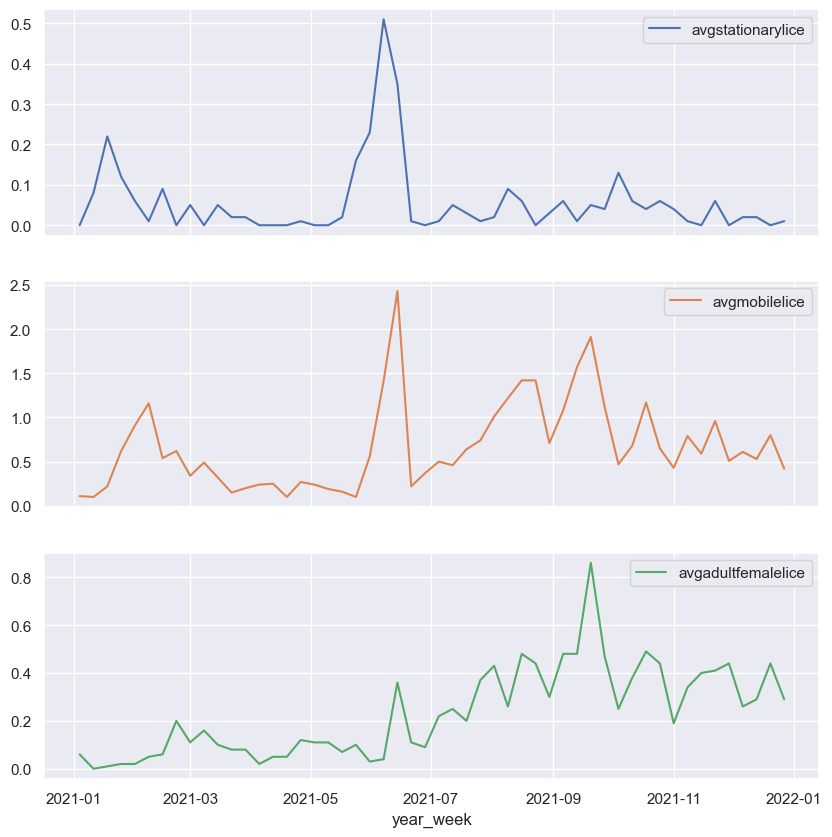

In [280]:
# plot avgstationarylice, avgmobilelice, avgfemalelice based on year_week, in 3 subplots
lice_count_table_plot = lice_count_table[['year_week','avgstationarylice','avgmobilelice','avgadultfemalelice']]
lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot.plot(subplots=True, figsize=(10,10))

plt.show()

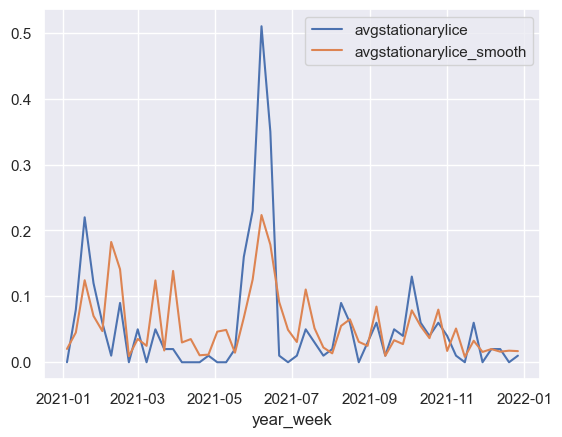

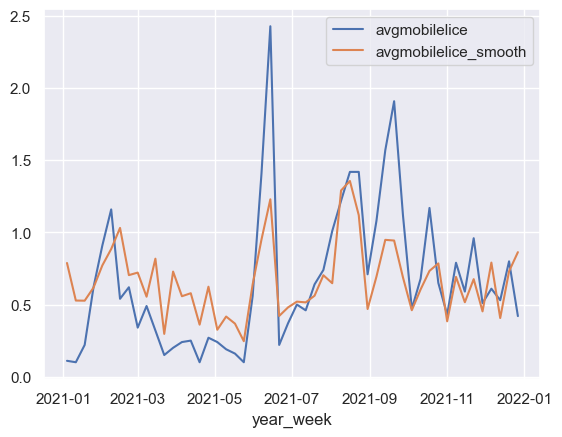

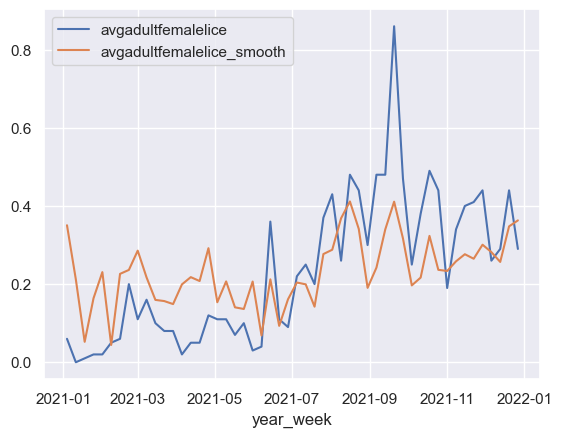

In [281]:
# do the same with gaussian filter
from scipy.ndimage import gaussian_filter1d
lice_count_table_plot = lice_count_table_plot.reset_index()

lice_count_table_plot['avgstationarylice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgstationarylice'], sigma=1)
lice_count_table_plot['avgmobilelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgmobilelice'], sigma=1)
lice_count_table_plot['avgadultfemalelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgadultfemalelice'], sigma=1)

lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot[['avgstationarylice','avgstationarylice_smooth']].plot()
lice_count_table_plot[['avgmobilelice','avgmobilelice_smooth']].plot()
lice_count_table_plot[['avgadultfemalelice','avgadultfemalelice_smooth']].plot()
plt.show()

#### sigma = 1 was the best smoothing parameter, the rest became a flat line

In [282]:
# Compute robust means and robust covariance for the raw data.
from sklearn.covariance import MinCovDet
robust_cov = MinCovDet().fit(lice_count_table_plot[['avgstationarylice','avgmobilelice','avgadultfemalelice']])
robust_mean = robust_cov.location_
robust_covariance = robust_cov.covariance_

# print the results
print('Robust location:')
print(robust_mean)
print('\nRobust covariance matrix:')
print(robust_covariance)

Robust location:
[0.02205882 0.51676471 0.22852941]

Robust covariance matrix:
[[0.00043988 0.00301548 0.00158538]
 [0.00301548 0.09302189 0.04201289]
 [0.00158538 0.04201289 0.02173019]]


In [283]:
# define function for Hotelling's T2
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)



In [284]:
# get relevant data
pdata = lice_count_table_plot[['avgstationarylice','avgmobilelice','avgadultfemalelice']].to_numpy()

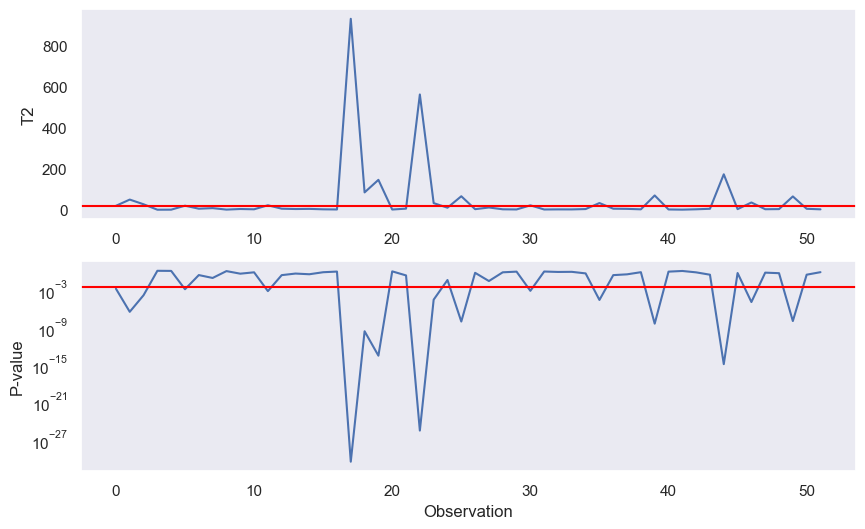

In [285]:
# import stats
from scipy import stats
#import numpy
import numpy as np
# Apply Hotellings_T2 and plot

alpha = 0.0027
T2, F, P, c = Hotellings_T2(pdata, robust_mean, robust_covariance, 52, alpha)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(T2)
plt.grid()
plt.axhline(c, color="red")

plt.ylabel("T2")
plt.subplot(212)
# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid()
plt.axhline(alpha, color="red")

plt.ylabel("P-value")
plt.xlabel("Observation")
plt.show()

In [286]:
# combine year and week into one column in lice_count_table
lice_count_table['year_week'] = lice_count_table['year'].astype(str) +'_'+ lice_count_table['week'].astype(str)

<h3> Weather data transforming

In [287]:
df_weather.dtypes


elementid                object
timeoffset               object
referencetime    datetime64[ns]
sourceid                 object
unit                     object
value                   float64
week                     UInt32
year                     UInt32
dtype: object

In [288]:
# sync the dataframe lice_table_year_plot with weather_table
df_weather.head(10)


,elementid,timeoffset,referencetime,sourceid,unit,value,week,year
0,mean(wind_speed P1D),PT0H,2021-01-01,SN65310:0,m/s,2.7,53,2020
1,mean(wind_speed P1D),PT0H,2021-01-02,SN65310:0,m/s,2.5,53,2020
2,mean(wind_speed P1D),PT0H,2021-01-03,SN65310:0,m/s,4.0,53,2020
3,mean(wind_speed P1D),PT0H,2021-01-04,SN65310:0,m/s,3.0,1,2021
4,mean(wind_speed P1D),PT0H,2021-01-05,SN65310:0,m/s,4.4,1,2021
5,mean(wind_speed P1D),PT0H,2021-01-06,SN65310:0,m/s,4.2,1,2021
6,mean(wind_speed P1D),PT0H,2021-01-07,SN65310:0,m/s,4.5,1,2021
7,mean(wind_speed P1D),PT0H,2021-01-08,SN65310:0,m/s,5.3,1,2021
8,mean(wind_speed P1D),PT0H,2021-01-09,SN65310:0,m/s,9.3,1,2021
9,mean(wind_speed P1D),PT0H,2021-01-10,SN65310:0,m/s,11.2,1,2021


In [289]:
# combine the year and week columns to one column
df_weather['year_week'] = df_weather['year'].astype(str) + '_' + df_weather['week'].astype(str)


In [290]:
df_weather.shape


(1820, 9)

In [291]:
df_weather.head(10)

,elementid,timeoffset,referencetime,sourceid,unit,value,week,year,year_week
0,mean(wind_speed P1D),PT0H,2021-01-01,SN65310:0,m/s,2.7,53,2020,2020_53
1,mean(wind_speed P1D),PT0H,2021-01-02,SN65310:0,m/s,2.5,53,2020,2020_53
2,mean(wind_speed P1D),PT0H,2021-01-03,SN65310:0,m/s,4.0,53,2020,2020_53
3,mean(wind_speed P1D),PT0H,2021-01-04,SN65310:0,m/s,3.0,1,2021,2021_1
4,mean(wind_speed P1D),PT0H,2021-01-05,SN65310:0,m/s,4.4,1,2021,2021_1
5,mean(wind_speed P1D),PT0H,2021-01-06,SN65310:0,m/s,4.2,1,2021,2021_1
6,mean(wind_speed P1D),PT0H,2021-01-07,SN65310:0,m/s,4.5,1,2021,2021_1
7,mean(wind_speed P1D),PT0H,2021-01-08,SN65310:0,m/s,5.3,1,2021,2021_1
8,mean(wind_speed P1D),PT0H,2021-01-09,SN65310:0,m/s,9.3,1,2021,2021_1
9,mean(wind_speed P1D),PT0H,2021-01-10,SN65310:0,m/s,11.2,1,2021,2021_1


In [292]:
# gruop by referencetime
df_weather = df_weather.groupby(['referencetime','elementid', 'week', 'year','unit', 'sourceid', 'year_week'] )
df_weather = df_weather['value'].mean()


In [293]:
df_weather = df_weather.reset_index()

In [294]:
df_weather.head(10)

#get dtypes
df_weather.dtypes

referencetime    datetime64[ns]
elementid                object
week                     UInt32
year                     UInt32
unit                     object
sourceid                 object
year_week                object
value                   float64
dtype: object

In [241]:
# Pivot the DataFrame based on the 'elementid' column
pivoted_df = df_weather.pivot(index=['referencetime', 'week', 'year', 'year_week'], columns='elementid', values='value')

# Reset the index to the default integer index
pivoted_df = pivoted_df.reset_index()

# Display the pivoted DataFrame
pivoted_df.head(10)

# gruop by referencetime
pivoted_df = pivoted_df.groupby(['referencetime','week', 'year', 'year_week'] )

In [242]:
pivoted_df = pivoted_df.mean().reset_index()

In [243]:
# drop week, year and year_week
pivoted_df = pivoted_df.drop(['week', 'year'], axis=1)

In [244]:
#drop index
pivoted_df = pivoted_df.reset_index(drop=True)

In [245]:
#set referencetime as index
pivoted_df = pivoted_df.set_index('referencetime')

In [246]:
pivoted_df.head(13)

elementid,year_week,mean(air_temperature P1D),mean(relative_humidity P1D),mean(wind_speed P1D),sum(precipitation_amount P1D)
referencetime,,,,,
2021-01-01,2020_53,1.25,81.0,2.7,0.0
2021-01-02,2020_53,1.40,75.0,2.5,0.0
2021-01-03,2020_53,1.85,81.0,4.0,0.0
2021-01-04,2021_1,1.25,82.0,3.0,0.0
2021-01-05,2021_1,1.40,76.0,4.4,0.0
2021-01-06,2021_1,1.55,73.0,4.2,0.0
2021-01-07,2021_1,1.55,77.0,4.5,0.0
2021-01-08,2021_1,1.85,77.0,5.3,0.0
2021-01-09,2021_1,2.65,69.0,9.3,0.0


In [247]:
# columnes to mean
columns_to_mean = ['mean(air_temperature P1D)', 'mean(relative_humidity P1D)', 'mean(wind_speed P1D)']
columns_to_sum = ['sum(precipitation_amount P1D)']

In [248]:
df_weekly = pivoted_df[columns_to_mean].resample('W').mean()

In [249]:
df_weekly_sum = pivoted_df[columns_to_sum].resample('W').sum()

In [250]:


df_weekly['sum(precipitation_amount P1D)'] = pivoted_df[columns_to_sum].resample('W').sum()

In [251]:
df_weekly['week'] = pivoted_df['year_week']

In [252]:
# drop if row includes nan
df_weekly = df_weekly.dropna(axis=0, how='any')

<h3>Combine the two df<h3>

In [50]:
#reset index
df_weekly = df_weekly.reset_index()
lice_count_table = lice_count_table.reset_index()

In [51]:
# inner join the two dataframes on week column in df_weekly and year_week column in lice_count_table
combine_df = pd.merge(df_weekly, lice_count_table, how='inner', left_on='week', right_on='year_week')

In [52]:
# keep referencetime	mean(air_temperature P1D)	mean(relative_humidity P1D)	mean(wind_speed P1D)	sum(precipitation_amount P1D) avgadultfemalelice	avgmobilelice	avgstationarylice	localityname
columns_to_keep = ['referencetime', 'mean(air_temperature P1D)', 'mean(relative_humidity P1D)', 'mean(wind_speed P1D)', 'sum(precipitation_amount P1D)', 'avgadultfemalelice', 'avgmobilelice', 'avgstationarylice','seatemperature' ,'localityname' ]
combine_df = combine_df[columns_to_keep]


In [53]:
combine_df.columns = combine_df.columns.str.lower()

column_mapping = {
    'referencetime': 'referencetime',
    'mean(air_temperature p1d)': 'mean_air_temperature',
    'mean(relative_humidity p1d)': 'mean_relative_humidity',
    'mean(wind_speed p1d)': 'mean_wind_speed',
    'sum(precipitation_amount p1d)': 'sum_precipitation_amount',
    'avgadultfemalelice': 'avgadultfemalelice',
    'avgmobilelice': 'avgmobilelice',
    'avgstationarylice': 'avgstationarylice',
    'seatemperature': 'seatemperature',
    'localityname': 'localityname'
}

# Assuming df is your DataFrame
combine_df = combine_df.rename(columns=column_mapping)
# save as csv
combine_df.to_csv('Data/combine_df.csv', index=False)


In [54]:
combine_df.head(10)

,referencetime,mean_air_temperature,mean_relative_humidity,mean_wind_speed,sum_precipitation_amount,avgadultfemalelice,avgmobilelice,avgstationarylice,seatemperature,localityname
0,2021-01-10,1.835714,76.428571,5.985714,8.4,0.06,0.11,0.00,6.9,Andholmen 1
1,2021-01-17,-0.342857,78.000000,4.728571,16.6,0.00,0.10,0.08,6.0,Andholmen 1
2,2021-01-24,3.657143,73.714286,5.714286,25.0,0.01,0.22,0.22,5.9,Andholmen 1
3,2021-01-31,2.471429,79.285714,8.928571,50.6,0.02,0.62,0.12,5.5,Andholmen 1
4,2021-02-07,-1.821429,65.857143,5.014286,3.5,0.02,0.91,0.06,5.1,Andholmen 1
5,2021-02-14,-0.692857,66.428571,7.128571,14.5,0.05,1.16,0.01,5.2,Andholmen 1
6,2021-02-21,4.107143,72.428571,4.671429,2.2,0.06,0.54,0.09,4.8,Andholmen 1
7,2021-02-28,6.485714,85.714286,10.414286,23.2,0.20,0.62,0.00,5.2,Andholmen 1
8,2021-03-07,4.235714,81.857143,10.257143,74.7,0.11,0.34,0.05,5.7,Andholmen 1
9,2021-03-14,4.178571,75.000000,6.500000,22.7,0.16,0.49,0.00,5.2,Andholmen 1


In [55]:
# drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.combine_table;")
# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS combine_table (
    referencetime DATE PRIMARY KEY,
    mean_air_temperature DOUBLE,
    mean_relative_humidity DOUBLE,
    mean_wind_speed DOUBLE,
    sum_precipitation_amount DOUBLE,
    avgadultfemalelice DOUBLE,
    avgmobilelice DOUBLE,
    avgstationarylice DOUBLE,
    seatemperature DOUBLE,
    localityname TEXT,
);
""")

In [56]:
# read the data from the csv file
combine_df = spark.read.csv('Data/combine_df.csv', header=True, inferSchema=True)

In [57]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "combine_table"

combine_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [58]:
# read from Cassandra - combined_table
df_combine = spark.read.format("org.apache.spark.sql.cassandra").options(table="combine_table", keyspace="fish_keyspace").load()
df_combine.show()

+-------------+------------------+-------------+-----------------+------------+--------------------+----------------------+------------------+--------------+------------------------+
|referencetime|avgadultfemalelice|avgmobilelice|avgstationarylice|localityname|mean_air_temperature|mean_relative_humidity|   mean_wind_speed|seatemperature|sum_precipitation_amount|
+-------------+------------------+-------------+-----------------+------------+--------------------+----------------------+------------------+--------------+------------------------+
|   2021-08-22|              0.48|         1.42|             0.06| Andholmen 1|  12.450000000000001|                  80.0| 6.214285714285714|          14.3|      17.099999999999998|
|   2021-03-07|              0.11|         0.34|             0.05| Andholmen 1|   4.235714285714286|     81.85714285714286|10.257142857142856|           5.7|                    74.7|
|   2021-09-19|              0.48|         1.57|             0.01| Andholmen 1|  12.2